In [166]:
import re
import pandas as pd
%pylab inline
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

import sys
# !pip install vaderSentiment
# !{sys.executable} -m pip install gensim
# import pysentiment as ps
# !{sys.executable} -m pip install pysentiment
# nltk.download('vader_lexicon')

from nltk import sentiment
from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import gensim
from gensim import corpora, models, similarities

Populating the interactive namespace from numpy and matplotlib


In [54]:
df = pd.read_csv(r'C:\Users\Abraham\MSBA\Text\Project\tweets_4_4.csv')
df.columns = ['ID','Screen_Name','Followers','Retweet','InReplyTo','Favorite','Friends','Listed','Location','Text']

df_raw = df[df['Location'].notnull()].drop_duplicates()

## Dummy for Texas

In [55]:
def findtx(s):
    intexas = 0
    s=str(s).lower()
    tx1 = re.findall('tx',s)
    tx2 = re.findall('texas',s)
    
    if len(tx1)>0 or len(tx2)>0:
        intexas = 1 
    return intexas

df_raw['Texas'] = 0
df_raw['Texas'] = df_raw['Location'].map(findtx)

## Dummy for Urban/City

In [56]:
citystr = 'houston|austin|san antonio|dallas|fort worth|dfw|atx|hou|htx|dtx|dal|el paso|corpus christi|\
sanantonio|fortworth|elpaso|laredo|arlington|plano|corpuschristi'

def findcities(s):
    urban = 0
    s=str(s).lower()
    citiesfound = re.findall(citystr,s)
    if len(citiesfound) > 0 :
        urban = 1
    return urban

df_raw['Urban'] = 0
df_raw['Urban'] = df_raw['Location'].map(findcities)

## Dummy for Candidates

In [57]:
def findbeto(s):
    beto = 0
    s = str(s).lower()
    txt1 = re.findall('beto',s)
    if len(txt1) > 0:
        beto = 1
    return beto

df_raw['Beto'] = df_raw['Text'].map(findbeto)

def findcruz(s):
    cruz = 0
    s = str(s).lower()
    txt1 = re.findall('cruz',s)
    if len(txt1) > 0:
        cruz = 1
    return cruz

df_raw['Cruz'] = df_raw['Text'].map(findcruz)

# Clean tweets

In [175]:
def processTweet(tweet):
    
    if tweet.startswith("RT"):
        i = tweet.index(':')
        tweet = tweet[i+2:]
    
    tweet = tweet.lower()
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    tweet = re.sub('([0-9]+)','', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('&amp;', '', tweet)
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    tweet = tweet.strip('\'"')
    return tweet

df_raw['Text']=df_raw['Text'].map(processTweet)

## Overal Sentiment for each tweet

In [176]:
#Returns compound sentiment score between -1 and 1
def getScores(s):
    score = SentimentIntensityAnalyzer().polarity_scores(s)
    return score['compound']

df_raw['Score'] = df_raw['Text'].map(getScores)

In [177]:
dftx = df_raw[df_raw['Texas']==1]

## Beto Sentiments in different regions

Nationwide Beto Sentiment:  0.014103557312252947


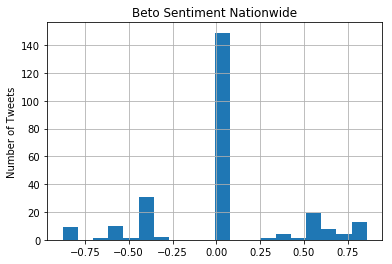

In [178]:
#Beto Sentiment Nationwide
df_raw[df_raw['Beto']==1]['Score'].hist(bins=20)
plt.title('Beto Sentiment Nationwide')
plt.ylabel('Number of Tweets')

senti_betonation = df_raw[df_raw['Beto']==1]['Score'].mean()
print('Nationwide Beto Sentiment: ', senti_betonation)

Texas Beto Sentiment:  -0.03628684210526315


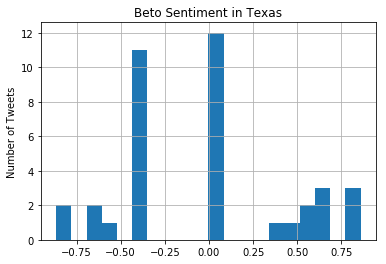

In [179]:
#Beto Sentiment in Texas
dftx[dftx['Beto']==1]['Score'].hist(bins=20)
plt.title('Beto Sentiment in Texas')
plt.ylabel('Number of Tweets')

senti_betotexas = dftx[dftx['Beto']==1]['Score'].mean()
print('Texas Beto Sentiment: ', senti_betotexas)

Texas Urban Beto Sentiment:  0.03915384615384616


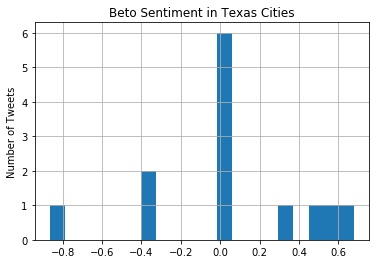

In [180]:
#Beto Sentiment in Texas Cities
dftx.loc[(dftx['Beto']==1) & (dftx['Urban']==1)]['Score'].hist(bins=20)
plt.title('Beto Sentiment in Texas Cities')
plt.ylabel('Number of Tweets')

senti_betotxurban = dftx.loc[(dftx['Beto']==1) & (dftx['Urban']==1)]['Score'].mean()
print('Texas Urban Beto Sentiment: ', senti_betotxurban)

Rural Texas Beto Sentiment:  -0.07551599999999997


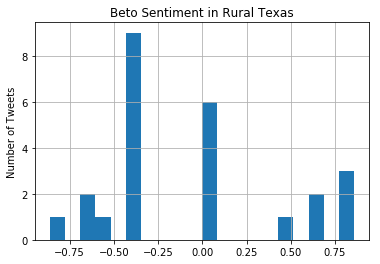

In [181]:
#Beto Sentiment in Rural Texas
dftx.loc[(dftx['Beto']==1) & (dftx['Urban']==0)]['Score'].hist(bins=20)
plt.title('Beto Sentiment in Rural Texas')
plt.ylabel('Number of Tweets')

senti_betotxrural = dftx.loc[(dftx['Beto']==1) & (dftx['Urban']==0)]['Score'].mean()
print('Rural Texas Beto Sentiment: ', senti_betotxrural)

## Cruz Sentiments in different regions

Nationwide Cruz Sentiment:  0.42262798165137416


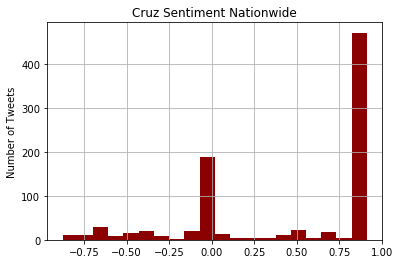

In [182]:
#Cruz Sentiment Nationwide
df_raw[df_raw['Cruz']==1]['Score'].hist(bins=20, color='darkred')
plt.title('Cruz Sentiment Nationwide')
plt.ylabel('Number of Tweets')

senti_cruznation = df_raw[df_raw['Cruz']==1]['Score'].mean()
print('Nationwide Cruz Sentiment: ', senti_cruznation)

Texas Cruz Sentiment:  0.3220249999999998


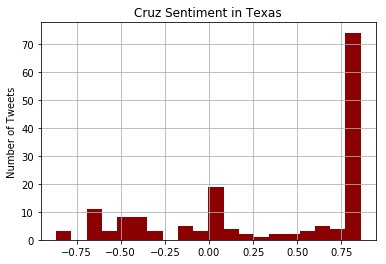

In [183]:
#Cruz Sentiment in Texas
dftx[dftx['Cruz']==1]['Score'].hist(bins=20, color='darkred')
plt.title('Cruz Sentiment in Texas')
plt.ylabel('Number of Tweets')

senti_cruztexas = dftx[dftx['Cruz']==1]['Score'].mean()
print('Texas Cruz Sentiment: ', senti_cruztexas)

Texas Urban Cruz Sentiment:  0.40395333333333305


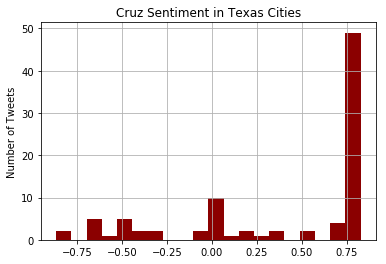

In [235]:
#Cruz Sentiment in Texas Cities
dftx.loc[(dftx['Cruz']==1) & (dftx['Urban']==1)]['Score'].hist(bins=20, color='darkred')
plt.title('Cruz Sentiment in Texas Cities')
plt.ylabel('Number of Tweets')

senti_cruztxurban = dftx.loc[(dftx['Cruz']==1) & (dftx['Urban']==1)]['Score'].mean()
print('Texas Urban Cruz Sentiment: ', senti_cruztxurban)

# print (dftx.loc[(dftx['Cruz']==1) & (dftx['Urban']==1)]['Location'].value_counts())

Rural Texas Cruz Sentiment:  0.2166885714285715


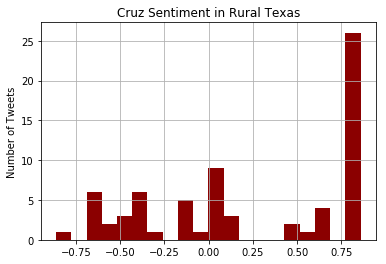

In [185]:
#Cruz Sentiment in Rural Texas
dftx.loc[(dftx['Cruz']==1) & (dftx['Urban']==0)]['Score'].hist(bins=20, color='darkred')
plt.title('Cruz Sentiment in Rural Texas')
plt.ylabel('Number of Tweets')

senti_cruztxrural = dftx.loc[(dftx['Cruz']==1) & (dftx['Urban']==0)]['Score'].mean()
print('Rural Texas Cruz Sentiment: ', senti_cruztxrural)

# Lift in Texas (urban vs rural)

In [186]:
prcruz = dftx['Cruz'].mean()
prbeto = dftx['Beto'].mean()
prcity = dftx['Urban'].mean() #About 52% urban

In [187]:
#Lift Cruz and City
cruzcity = dftx[dftx['Cruz']==1]['Urban'].sum()
prcruzcity = cruzcity/len(dftx)

lift_cruzcity = prcruzcity/(prcruz*prcity)
lift_cruzcity

1.0747767857142858

In [188]:
#Lift Cruz and Rural
cruzrural = len(dftx[dftx['Cruz']==1]['Urban']) - cruzcity
prcruzrural = cruzrural/len(dftx)

lift_cruzrural = prcruzrural/(prcruz*(1-prcity))
lift_cruzrural

0.917892156862745

In [189]:
#Lift Beto and City
betocity = dftx[dftx['Beto']==1]['Urban'].sum()
prbetocity = betocity/len(dftx)

lift_betocity = prbetocity/(prbeto*prcity)
lift_betocity

0.6536654135338347

In [190]:
#Lift Beto and Rural
betorural = len(dftx[dftx['Beto']==1]['Urban']) - betocity
prbetorural = betorural/len(dftx)

lift_betorural = prbetorural/(prbeto*(1-prcity))
lift_betorural

1.3802889576883384

# Ted Cruz Topics

In [191]:
cruztweets = dftx[dftx['Cruz']==1]['Text']

In [216]:
stemmer = SnowballStemmer('english')
# def lemmatize_stemming(text):
#     return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

cruzwords = cruztweets.map(preprocess)

In [219]:
cruz_dt = gensim.corpora.Dictionary(cruzwords)

cruz_bow = [cruz_dt.doc2bow(tweet) for tweet in cruzwords]

bow_tweet_1 = cruz_bow[1]

#Print sample breakdown
for i in range(len(bow_tweet_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_tweet_1[i][0], 
                                                     cruz_dt[bow_tweet_1[i][0]], 
                                                     bow_tweet_1[i][1]))

Word 0 ("cruz") appears 1 time.
Word 2 ("register") appears 1 time.
Word 3 ("texas") appears 1 time.
Word 5 ("vote") appears 1 time.
Word 6 ("dont") appears 1 time.
Word 7 ("tomorrow") appears 1 time.


In [226]:
cruz_tfidf = models.TfidfModel(cruz_bow)
cruz_model = cruz_tfidf[cruz_bow]
lda_model_tfidf = gensim.models.LdaMulticore(cruz_model, num_topics=10, id2word=cruz_dt, passes=2, workers=4)

In [227]:
df_topics = pd.DataFrame(lda_model_tfidf.print_topics(5))
for r in range(len(df_topics)):
    print (df_topics.iloc[r][1])
    print (' ')

0.038*"tomorrow" + 0.038*"doubts" + 0.038*"endorsed" + 0.038*"becaus" + 0.038*"conservative" + 0.037*"dont" + 0.033*"register" + 0.031*"texas" + 0.029*"november" + 0.021*"prosperous"
 
0.114*"fuck" + 0.111*"registered" + 0.053*"today" + 0.028*"november" + 0.023*"register" + 0.021*"cause" + 0.019*"refuse" + 0.019*"leading" + 0.017*"friends" + 0.015*"party"
 
0.030*"beto" + 0.023*"socialism" + 0.023*"wants" + 0.021*"stuck" + 0.021*"voting" + 0.021*"said" + 0.021*"uhhhhhh" + 0.021*"girl" + 0.021*"bitch" + 0.021*"class"
 
0.022*"beto" + 0.019*"county" + 0.019*"tarrant" + 0.019*"signs" + 0.018*"great" + 0.018*"state" + 0.018*"lead" + 0.017*"fellow" + 0.017*"alamo" + 0.017*"burning"
 
0.175*"tomorrow" + 0.169*"dont" + 0.150*"register" + 0.106*"texas" + 0.044*"vote" + 0.008*"rule" + 0.007*"depends" + 0.007*"november" + 0.006*"freedom" + 0.006*"family"
 
